In [1]:
# Install Qiskit version 2.2.3 or higher

# pip install 'qiskit>=2.2.3' 
# pip install 'qiskit-ibm-runtime>=0.43.1'

# Optional: Install additional Qiskit packages for visualization and Jupyter notebook support

# pip install qiskit[visualization]
# pip install jupyter

# Moeda Classica

Sendo uma moeda 50/50, onde:

 \begin{array}{l}
P( cara) \ =\ 0,5\\
P( coroa) \ =\ 0,5\ 
\end{array}

Em 1000 lançamentos (flips) se espera, em teoria a mesma quantidade de resultados para ambos os lados da moeda.

$$1000 \cdot 0,5 = 500$$

Número de Lançamentos: 1000
Contagem de Coroas: 515
Contagem de Caras: 485


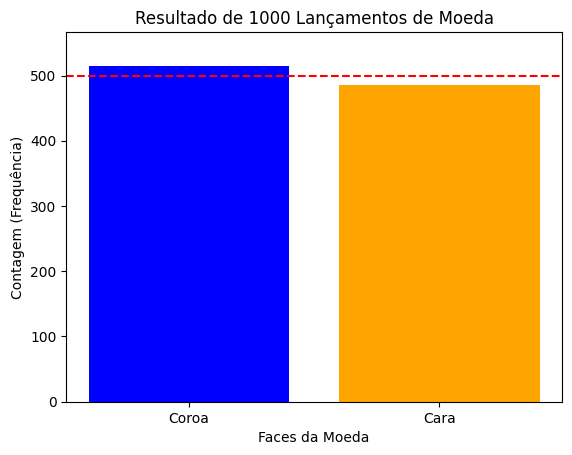

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

nflips = 1000
fliplist = [random.randint(0, 1) for f in range(nflips)]

count_coroa = fliplist.count(0)
count_cara = fliplist.count(1)

devio_padrao = np.std(fliplist)
variancia = np.var(fliplist)

print(f'Número de Lançamentos: {nflips}')
print(f'Contagem de Coroas: {count_coroa}')
print(f'Contagem de Caras: {count_cara}')

labels = ['Coroa', 'Cara']
counts = [count_coroa, count_cara]

plt.bar(labels, counts, 
        color=['blue', 'orange'], 
        label='Resultado Real')

expected_value = nflips / 2
plt.axhline(y=expected_value, 
            color='red', 
            linestyle='--')

plt.xlabel('Faces da Moeda')
plt.ylabel('Contagem (Frequência)')
plt.title(f'Resultado de {nflips} Lançamentos de Moeda')

max_height = max(max(counts), expected_value)
plt.ylim(bottom=0, 
         top=max_height * 1.1)
plt.show()

# Moeda Quantica

Considerando o estado $|0\rangle$ como coroa e o $|1\rangle$ como cara.

$$
|\psi\rangle = \frac{1}{\sqrt{2}} |0\rangle + \frac{1}{\sqrt{2}} |1\rangle
$$


\begin{array}{l}
P( 0) =\left(\frac{1}{\sqrt{2}}\right)^{2} =0,5\\
\\
P( 1) =\left(\frac{1}{\sqrt{2}}\right)^{2} =0,5
\end{array}

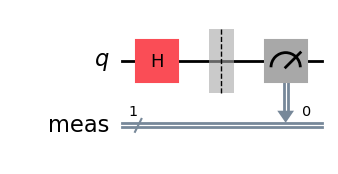

In [3]:
from qiskit import QuantumCircuit # Classe para criar circuitos quânticos

qcoin = QuantumCircuit(1); # Objeto circuito quântico com 1 qubit

# Aplicação das portas quânticas
qcoin.h(0); # Porta Hadamard 

qcoin.measure_all(); # Medição de todos os qubits

qcoin.draw('mpl') 

- Todo qubit q começa no estado fundamental $|0\rangle$
- A Porta Hadamard que trasforma q desse estado inicial para o estado de superposição
- Quando o medimos, a superposição colapsa. O qubit deve escolher ser 0 ou 1.
- meas é um "registro clássico".

    

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService # Cuida da autenticação e conexão com a IBM Quantum

channel = 'ibm_quantum_platform' # Canal de comunicação com a IBM Quantum
istanceCRN = 'crn:v1:bluemix:public:quantum-computing:us-east:a/a3e2677a146e4e05a7cce929933bc2b7:850e2417-787c-4a71-bdb2-e6c5ea1f98c8::' # Codigo da instância criada
token = 'z6LD5d6oyIbOEvvX1NGtIVWlaUYLYquyuHp2MWFB3FeS' # Token da API

QiskitRuntimeService.save_account( # Salva as credenciais da conta IBM Quantum
    channel=channel,
    token=token,
    instance=istanceCRN,
    overwrite=True,
    set_as_default=True                              
)

service = QiskitRuntimeService(channel=channel) # Cria o serviço de runtime da IBM Quantum
service = QiskitRuntimeService() # Usa a conta padrão salva 

## Primitives

Os Primitives são as interfaces padronizadas e de alto nível que o Qiskit oferece para interagir com computadores quânticos e simuladores. Em vez de você ter que lidar com os detalhes complexos de como um job (trabalho) é formatado, enviado e processado, os Primitives simplificam tudo em duas tarefas principais:

1.  **Amostragem (Sampling):** Obter a distribuição de probabilidade dos resultados de um circuito.

2.  **Estimativa (Estimating):** Calcular o valor esperado de um observável quântico.

### SamplerV2

Sua função é pegar um circuito quântico, executá-lo um determinado número de vezes (`shots`) e retornar as contagens de cada resultado.

### EstimatorV2 

Sua função é mais complexa. Ele pega um circuito (que prepara um estado quântico) e um **observável** (uma propriedade física que você quer medir, como o Pauli-Z ou Pauli-X) e calcula o **valor esperado** desse observável.

In [5]:
from qiskit_ibm_runtime import ( 
    SamplerV2 as Sampler, # Classe para executar circuitos quânticos
    EstimatorV2 as Estimator, # Classe para estimar valores esperados
)

backend = service.least_busy()
print(f'Backend selecionado: {backend.name}')

Backend selecionado: ibm_fez


## Transpilação 

A transpilação é o processo de "compilar" um circuito quântico ideal para que ele possa ser executado em um hardware quântico específico. Assim como um compilador de computador clássico traduz código de alto nível para a linguagem de máquina, o transpiler do Qiskit adapta o circuito abstrato à realidade física do processador: ele decompõe as portas em operações nativas do hardware, otimiza o circuito para reduzir o número de operações e o ruído, e mapeia os qubits virtuais para qubits físicos, considerando as conexões existentes entre eles. Essencialmente, é um passo crucial de tradução e otimização que aumenta a fidelidade dos resultados ao minimizar o impacto das imperfeições do hardware quântico atual.

### Pass Manager

O transpiler do Qiskit funciona como uma linha de montagem. Ele aplica uma série de transformações (chamadas de "passes") ao seu circuito. Cada "pass" faz uma coisa específica: troca uma porta por outra, otimiza uma sequência de portas, mapeia qubits virtuais para físicos, etc. Um Pass Manager é quem organiza e executa essa sequência de passes.

`optimization_level=3`: Este é um parâmetro crucial. Ele define o quão "agressivamente" o transpiler deve tentar otimizar o circuito.

*   **`0`**: Apenas mapeia o circuito para o backend, sem otimização. Rápido, mas o circuito resultante pode ser muito ruidoso.

*   **`1`**: Otimização leve. Um bom equilíbrio entre tempo de transpilação e qualidade do circuito.

*   **`2`**: Otimização pesada.

*   **`3`**: **Otimização mais pesada.** Tenta várias estratégias para encontrar o melhor mapeamento de qubits e a melhor decomposição de portas para minimizar o erro. Leva mais tempo para transpilar, mas geralmente resulta em um circuito com maior fidelidade (melhores resultados).


### ISA: Instruction Set Architecture (Arquitetura do Conjunto de Instruções)

No contexto da computação, seja clássica ou quântica, a **Instruction Set Architecture (ISA)** define a interface abstrata entre o hardware e o software de mais baixo nível. Ela especifica o conjunto de operações primitivas (instruções) que um processador específico pode executar diretamente, assim como os registradores, modos de endereçamento e formatos de dados que ele suporta.

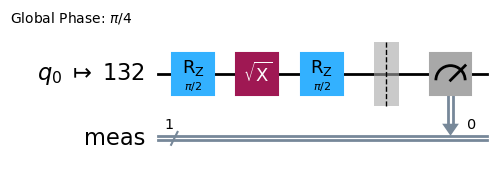

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target # Obtem as características do backend quantum para otimização do circuito
pm = generate_preset_pass_manager(target=target, optimization_level=3) 

qcoin_isa = pm.run(qcoin)  # Transpila o circuito quântico para para o formato ISA 
qcoin_isa.draw('mpl')

## Execução

### Unidade Pub

Um "pub" (Primitive Unified Blocs ou "publicações") é a unidade fundamental de trabalho. Para o Sampler, um pub simples é apenas o circuito quântico que você quer executar.

### job

Este objeto atua como um "recibo" ou um "ponteiro" para o seu trabalho que fica está na fila de execução do backend da IBM.

### result

O objeto result é um contêiner estruturado que organiza os resultados por experimento ("pub"). Para o Sampler, o caminho para obter a informação mais útil (as contagens) é navegar por essa estrutura: 

result[<índice_do_pub>].data.meas.get_counts().

 Essa estrutura foi projetada para ser flexível e escalável, permitindo que os Primitives retornem diferentes tipos de dados de maneira organizada e unificada.


In [7]:
sampler = Sampler(mode=backend) # Instancia do Sampler para executar o circuito quântico

pubs = [qcoin_isa] 
# pub é uma unidade fundamental de trabalho para uma execução quântica

job = sampler.run(pubs, shots=1000) # Envia o trabalho para execução no backend quântico
result = job.result() # Obtém o resultado do trabalho executado

# pub_result = result[0] # Dados do primeiro pub 
# data_conteiner = pub_result.data # Databin, armazena os resultados da execução como um conteiner de dados
# semples = data_conteiner.meas # Resultados de medição obtidos

counts = result[0].data.meas.get_counts() # Obtém a contagem das frequências dos resultados medidos em dicionário


Número de Lançamentos: 1000
Contagem de Coroas: 511
Contagem de Caras: 489


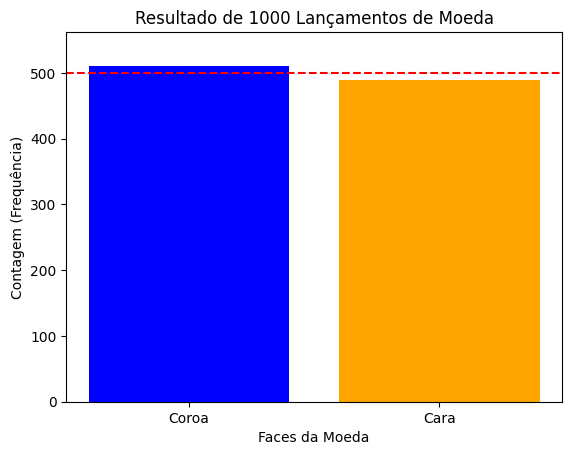

In [8]:
count_coroa = counts.get('0', 0) 
count_cara = counts.get('1', 0)

print(f'Número de Lançamentos: {1000}')
print(f'Contagem de Coroas: {count_coroa}')
print(f'Contagem de Caras: {count_cara}')

labels = ['Coroa', 'Cara']
counts = [count_coroa, count_cara]

plt.bar(labels, counts, 
        color=['blue', 'orange'], 
        label='Resultado Real')

expected_value = nflips / 2
plt.axhline(y=expected_value, 
            color='red', 
            linestyle='--')

plt.xlabel('Faces da Moeda')
plt.ylabel('Contagem (Frequência)')
plt.title(f'Resultado de {nflips} Lançamentos de Moeda')

max_height = max(max(counts), expected_value)
plt.ylim(bottom=0, 
         top=max_height * 1.1)
plt.show()

| Característica | Computação Clássica (Moeda Clássica) | Computação Quântica (Moeda Quântica) |
| :--- | :--- | :--- |
| **Fundamento Teórico** | Teoria da Probabilidade Clássica. | Mecânica Quântica (Postulados da MQ). |
| **Unidade de Informação**| Bit clássico (pode ser 0 ou 1). | Qubit (pode ser 0, 1, ou uma superposição de ambos). |
| **Geração de Aleatoriedade**| **Algoritmo pseudo-aleatório** (`random.randint`). Um computador clássico é determinístico; a aleatoriedade é simulada. | **Medição de um estado quântico**. Considerada fundamentalmente aleatória pela teoria quântica. |
| **Representação do Estado**| Uma distribuição de probabilidade (ex: 50% cara, 50% coroa). Os valores são números reais e positivos. | Um **vetor de estado** com **amplitudes complexas**. A probabilidade é o quadrado da magnitude da amplitude (Regra de Born). |
| **Operação "Lançamento"**| Chamada de uma função de software (`random.randint`). | Aplicação de uma **porta quântica** (porta Hadamard, `H`). É uma operação física sobre o qubit. |
| **Execução** | Executado inteiramente em uma CPU. | **Transpilado** para a ISA do hardware e executado em um Processador Quântico (QPU) ou um simulador quântico. |
| **Ferramentas** | Bibliotecas padrão como `random`, `numpy`, `matplotlib`. | Bibliotecas especializadas como `Qiskit`, `qiskit-ibm-runtime`. |